# IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
%config Completer.use_jedi = False

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# LOADING DATA

In [3]:
# Read the yelp.csv file and set it as a dataframe called yelp.

yelp = pd.read_csv('yelp.csv')

In [4]:
# Looking at the yelp data

yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
yelp.info(verbose = True, null_counts = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   business_id  object
 1   date         object
 2   review_id    object
 3   stars        int64 
 4   text         object
 5   type         object
 6   user_id      object
 7   cool         int64 
 8   useful       int64 
 9   funny        int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [6]:
# Having a look at some basic statistical details.

yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [7]:
# Created a new column called "text length" which is the number of words in the text column.

yelp['text length'] = yelp['text'].apply(len)

# EXPLORATORY DATA ANALYSIS (EDA)

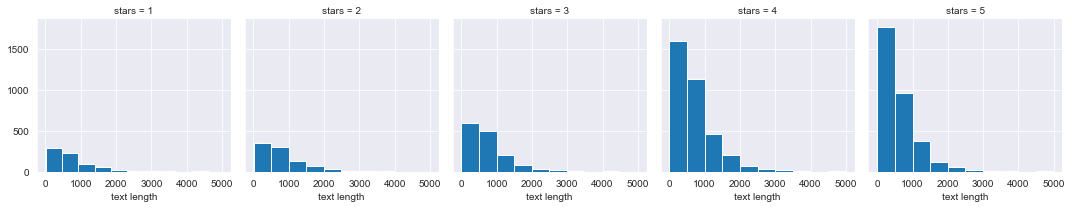

In [8]:
# Used FacetGrid from the seaborn library to create a grid of 5 histograms of text length based off of the star ratings. 

g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist,'text length')

<AxesSubplot:xlabel='stars', ylabel='text length'>

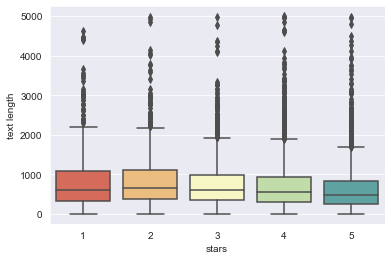

In [9]:
# Created a boxplot of text length for each star category.

sns.boxplot(x='stars',y='text length',data=yelp,palette='Spectral')

<AxesSubplot:xlabel='stars', ylabel='count'>

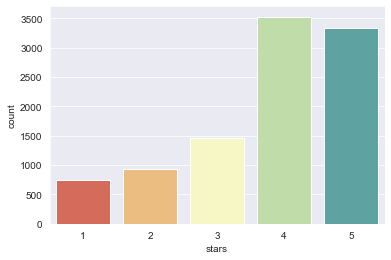

In [10]:
# Created a countplot of the number of occurrences for each type of star rating.

sns.countplot(x='stars',data=yelp,palette='Spectral')

In [11]:
# Used groupby to get the mean values of the numerical columns.

stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [12]:
# Used the corr() method on the above groupby dataframe

stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


<AxesSubplot:>

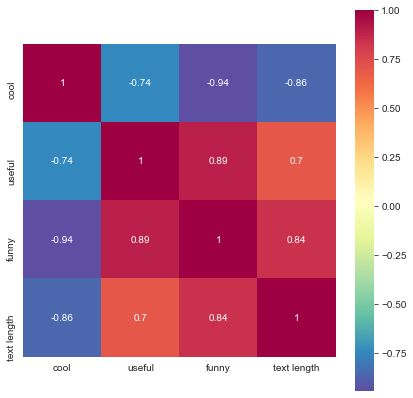

In [13]:
# Created a heatmap based off the above .corr() dataframe

plt.subplots(figsize=(7,7))
sns.heatmap(stars.corr(),cmap='Spectral_r',annot=True, square=True)

# NLP CLASSIFICATION TASK

In [14]:
# Created a dataframe called yelp_class that contains the columns of yelp dataframe but for only the 1 or 5 star reviews.

yelp_class = yelp[(yelp.stars==1) | (yelp.stars==5)]
yelp_class

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565
...,...,...,...,...,...,...,...,...,...,...,...
9990,R8VwdLyvsp9iybNqRvm94g,2011-10-03,pcEeHdAJPoFNF23es0kKWg,5,Yes I do rock the hipster joints. I dig this ...,review,b92Y3tyWTQQZ5FLifex62Q,1,1,1,263
9991,WJ5mq4EiWYAA4Vif0xDfdg,2011-12-05,EuHX-39FR7tyyG1ElvN1Jw,5,Only 4 stars? \n\n(A few notes: The folks that...,review,hTau-iNZFwoNsPCaiIUTEA,1,1,0,908
9992,f96lWMIAUhYIYy9gOktivQ,2009-03-10,YF17z7HWlMj6aezZc-pVEw,5,I'm not normally one to jump at reviewing a ch...,review,W_QXYA7A0IhMrvbckz7eVg,2,3,2,1326
9994,L3BSpFvxcNf3T_teitgt6A,2012-03-19,0nxb1gIGFgk3WbC5zwhKZg,5,Let's see...what is there NOT to like about Su...,review,OzOZv-Knlw3oz9K5Kh5S6A,1,2,1,1968


In [15]:
# Created two objects X and y.

X = yelp_class['text']
y = yelp_class['stars']

In [16]:
cv = CountVectorizer()

In [17]:
# Used the fit_transform method on the CountVectorizer object and pass in X.

X = cv.fit_transform(X)

## Train Test Split

In [18]:
# Used train_test_split to split up the data into X_train, X_test, y_train, y_test and Used test_size=0.3 and random_state=101

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 101)

## Training a Model

In [19]:
# Created an instance of the estimator and call is nb.

nb = MultinomialNB()

In [20]:
# Fitted nb using the training data.

nb.fit(X_train,y_train)

MultinomialNB()

## Predictions and Evaluations

In [21]:
# Used the predict method off of nb to predict labels from X_test.

predictions = nb.predict(X_test)

In [22]:
# Classification Report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



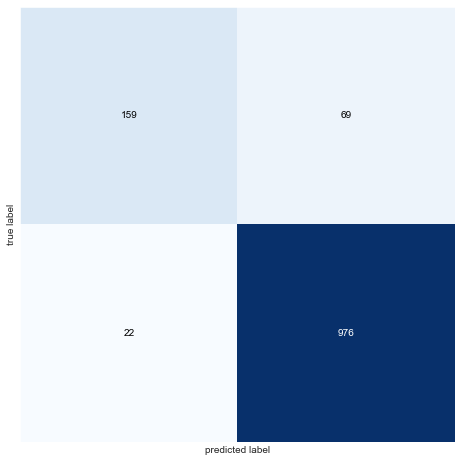

In [23]:
# Confusion Matrix

plot_confusion_matrix(confusion_matrix(y_test, predictions), figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

# USING TEXT PROCESSING

In [24]:
# Created a pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# Using the Pipeline

## Train Test Split

Redo the train test split on the yelp_class object.

In [25]:
# Fitted the pipeline to the training data.

X = yelp_class['text']
y = yelp_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [26]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

## Predictions and Evaluation

In [27]:
# Used the pipeline to predict from the X_test.

predictions = pipeline.predict(X_test)

In [28]:
# Classification Report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



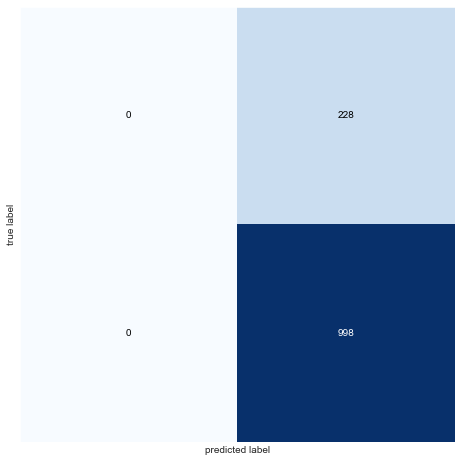

In [29]:
# Confusion Matrix

plot_confusion_matrix(confusion_matrix(y_test, predictions), figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.show()

# CONCLUSION

Here, I observed that the Tf-Idf method instead of improving it made things worse in the case of this project.